<a href="https://colab.research.google.com/github/pauchai/SubPlayer/blob/master/Paul%20Himyak/Profpatolog_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рекомендательная система для профпатолога (INSPECTRUM CLINIC)



# запустить...

In [1]:
!python3 -m pip install -q git+https://github.com/keras-team/keras-tuner.git
!python3 -m pip install -q autokeras

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q tensorflow-addons

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import re
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import concatenate, Embedding, Conv1D, Input, Dense, Dropout, BatchNormalization, Flatten , SpatialDropout1D, Reshape, RepeatVector, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
from tensorflow.keras import utils

import tensorflow as tf
import tensorflow_addons as tfad

import sklearn.metrics as skl_metrics
from sklearn.model_selection import train_test_split

from scipy.stats import norm

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import autokeras as ak





/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
FIELD_CLIENT_AGE = "Age"
FIELD_CLIENT_BIRTH_DAY = "КлиентДатаРождения"
FIELD_CLIENT_GENDER = "КлиентПол"
FIELD_CLIENT_GENDER_M = "Мужской"
FIELD_CLIENT_GENDER_F = "Женский"
FIELD_CLIENT_GENDER_ENCODED = "Gender"
FIELD_CONCLUSION = "ЗаключениеМК"
FIELD_CONCLUSION_FIT = "Годен"
FIELD_CONCLUSION_PART_FIT = "Ограничено годен"
FIELD_CONCLUSION_NOT_FIT = "Не годен"
FIELD_CONCLUSION_ENCODED = "Conclusion"

FIELD_DISPANSARY_GROUP = "ДиспансернаяГруппа"
FIELD_DISPANSARY_GROUP_I = "I"
FIELD_DISPANSARY_GROUP_II = "II"
FIELD_DISPANSARY_GROUP_III = "III"
FIELD_DISPANSARY_GROUP_OTHER = "другая"
FIELD_DISPANSARY_GROUP_ENCODED = "Dispansary Group"

FIELD_HARMFUL_FACTORS = "ВредныеФакторы"
FIELD_HARMFUL_FACTORS_ENCODED = "Harful factors"


FIELD_NEW_AGE_CATEGORY = "ВозрастКатегория"

FIELD_NEW_MKBS = "mkbs"
FIELD_NEW_MKBS_ENCODED = "mkbs_encoded"

FIELD_CLIENT_PROFESSION = "Профессия"
FIELD_CLIENT_PROFESSION_ENCODED = "Profession"

FIELD_NEW_CLIENT_ADDITIONS = "Дополнения сводные"
FIELD_NEW_CLIENT_ADDITIONS_ENCODED = "Дополнения сводные encoded"

FIELD_NEW_CLIENT_DIAG = "Diagnoz"
FIELD_NEW_CLIENT_DIAG_ENCODED = "Diagnoz Encoded"


In [5]:
class MyUtils:
  conclusion_map = {FIELD_CONCLUSION_FIT:'Годен', FIELD_CONCLUSION_PART_FIT:"Частично годен", FIELD_CONCLUSION_NOT_FIT: 'Негоден'}
  @classmethod
  def conclusion_labels(cls):
    return  [cls.conclusion_map[k] for k in sorted(cls.conclusion_map)]

  @classmethod
  def resolve_conclusion_map(cls,x):
    return cls.conclusion_map[x]
  @staticmethod
  # Определяем функцию для расчета возраста на основе даты
  def resolve_birthdate_to_age(date):
    current_year = pd.Timestamp.now().year
    age = current_year - date.year
    return age
  def resolve_genger(x):
    if x == 'Мужской':
        return FIELD_CLIENT_GENDER_M
    elif x == 'Женский':
        return FIELD_CLIENT_GENDER_F
    else:
        return None

  def resolve_conclusion_binary(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_conclusion(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      elif "Негоден" in arg:
        return FIELD_CONCLUSION_NOT_FIT
      elif "Годен" in arg:
        return FIELD_CONCLUSION_PART_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_dispansary_group(arg):
    try:
      if arg == "I":
        return FIELD_DISPANSARY_GROUP_I
      elif arg == "II":
        return FIELD_DISPANSARY_GROUP_II
      elif "III" in arg :
        return FIELD_DISPANSARY_GROUP_III
      else:
        return FIELD_DISPANSARY_GROUP_OTHER
    except (TypeError):
        return None
  def resolve_age_to_category(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [6]:
def print_df_shape(df):
  print("записей:{}".format(df.shape[0]), " колонок:{}".format(df.shape[1]))

In [7]:
class AgeCategoryEncoder:
  num_categories:int = None
  _classes = None
  def __init__(self, num_categories:int = 5):
    self.num_categories = num_categories

  def fit_transform(self, arr:np.ndarray):
      self._initialize_classes(arr)
      result = np.digitize(arr, self._classes)
      result -= 1
      return result

  def _initialize_classes(self, arr:np.ndarray):
    mu, std = norm.fit(arr)
    percentiles = np.linspace(0, 100, self.num_categories + 1)
    self._classes = [norm.ppf(i/100., mu, std) for i in percentiles]
    self._classes[-1] = np.inf

  def inverse_transform(self, arr:np.array):
    vfunc = np.vectorize(lambda x: (self._classes[x], self._classes[x+1]) if x+1 < len(self._classes) else (self._classes[x], np.inf))
    return vfunc(arr)



In [8]:
np_len = np.vectorize(len)


class MySequences:
  value = None
  max_len = None
  def get_padded(self):
    return pad_sequences(self.value, maxlen=self.max_len, padding='post')


class MyTokenizer:
  tokenizer:Tokenizer
  _indexed = None
  def __init__(self, *tokenizer_args, **tokenizer_kwargs):
    self.tokenizer = Tokenizer(*tokenizer_args, **tokenizer_kwargs)

  @property
  def vocab_size(self):
    return len(self.tokenizer.word_index) + 1

  def fit_on_texts(self, series):
    self.tokenizer.fit_on_texts(series)

  def texts_to_sequences(self, series):

    self._indexed = MySequences()


    self._indexed.value = self.tokenizer.texts_to_sequences(series)
    self._indexed.max_len = np_len(self._indexed.value).max()
    return self._indexed

  def process_data(self, series):
    self.fit_on_texts(series)
    self.texts_to_sequences(series)

  @property
  def indexed(self)->MySequences:
    return self._indexed

  def __call__(self):
    return self.tokenizer

In [9]:
#функция из названя столбца выделяет первое значение
def extract_specialist_from_column_name(string):
    # Выделить первую часть до символа `_`
    first_part = string.split("_")[0]

    # Разбить первую часть на слова по стилю CamelCase и исключить цифры
    words = re.findall('[A-ZА-ЯЁ][a-zа-яё]*', first_part)

    # Объединить слова в строку с пробелами
    result = ' '.join(words)

    return result
extract_specialist_from_column_name("ПсихиатрияНаркология1_ДиагнозПредставление1")

'Психиатрия Наркология'

In [10]:
#функция объединения ячеек в одну удаляя ненужный символ и объединяя вместе с названиями колонок
def join_not_nan_columns(df, columns_filter, value_for_unset = None):
  if value_for_unset is not None:
    df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)
  return df[columns_filter.columns].apply(lambda row: ",".join(f"{extract_specialist_from_column_name(column_name)} {value}" for column_name, value in zip(columns_filter.columns, row) if pd.notna(value)), axis=1)



In [75]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, target = 'recall', x_size = 25, y_size = 10):

  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history[target],
         label='Ошибка на обучающей выборке')

  plt.plot(history.history['val_' + target],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [144]:
def compare_f1_score(history, label_encoder):
  train_f1scores = np.array(history.history['f1_score'])
  val_f1scores = np.array(history.history['val_f1_score'])
  plt.figure(figsize=(10,5))

  for class_idx in range(len(label_encoder.classes_)):
      color = f'C{class_idx}'
      plt.plot(train_f1scores[:, class_idx], color=color, linestyle = '-', label=f'Training (Class {label_encoder.classes_[class_idx]})')
      plt.plot(val_f1scores[:, class_idx], color=color, linestyle = '--',label=f'Validation (Class {label_encoder.classes_[class_idx]})')

  plt.legend(fontsize='small')

  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя f1score')

  #plt.title("Training and Validation F1 Score by Class")

  plt.show()

In [159]:
def model_evaluate(y_pred, y_test):
  cm = confusion_matrix(np.argmax(y_test, axis=-1),
                          np.argmax(y_pred, axis=-1),
                          normalize='true')
  figsize = (10,10)
  title = "матрица ошибок"
  # Отрисовка матрицы ошибок
  fig, ax = plt.subplots(figsize=figsize)
  ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=conclusion_le.classes_)
  disp.plot(ax=ax)
  plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
  plt.xlabel('Предсказанные классы', fontsize=16)
  plt.ylabel('Верные классы', fontsize=16)
  fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
  plt.show()


# Получение  данных и предварительная чистка

Получаем датасет

In [11]:
!wget -qc "https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx"
df = pd.read_excel("датасет профпатолог часть.xlsx")

In [12]:
print_df_shape(df)

записей:1982  колонок:4587


Удалим некорректные записи и пустые колонки

In [13]:
df.drop([843, 851, 1022, 1024], inplace = True)
empty_columns = df.columns[df.isna().all()]
df.drop(empty_columns, inplace = True, axis = 1)

In [14]:
print_df_shape(df)

записей:1978  колонок:3673


# Анализ колонок категориального типа

Согласно Техническому Заданию (ТЗ) целевой колонкой для предсказания системы определена ***ЗаключениеМК***.



In [19]:
df[FIELD_CONCLUSION].value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

Было согласовано с заказчиком привести целевую колонку  к 3 классам . **годен** , **не годен** и **ограничено годен**.

In [20]:
df[FIELD_CONCLUSION] = df[FIELD_CONCLUSION].apply(lambda x: MyUtils.resolve_conclusion(x))

In [21]:
df[FIELD_CONCLUSION].value_counts()


Годен               1434
Ограничено годен     126
Не годен              11
Name: ЗаключениеМК, dtype: int64

Диспансерные привожу к трем

In [22]:
df[FIELD_DISPANSARY_GROUP].value_counts()

I       779
II      389
IIIа    369
IIIб     25
Name: ДиспансернаяГруппа, dtype: int64

In [23]:
df[FIELD_DISPANSARY_GROUP] = df[FIELD_DISPANSARY_GROUP].apply(MyUtils.resolve_dispansary_group)

In [24]:
df[FIELD_DISPANSARY_GROUP].value_counts()

I      779
III    394
II     389
Name: ДиспансернаяГруппа, dtype: int64

День рождения преобразую в возраст

In [25]:
df[FIELD_CLIENT_AGE] = df[FIELD_CLIENT_BIRTH_DAY].apply(MyUtils.resolve_birthdate_to_age)


In [26]:
base_columns = [FIELD_CLIENT_BIRTH_DAY, FIELD_CLIENT_GENDER, FIELD_CONCLUSION, FIELD_DISPANSARY_GROUP]


In [27]:
df[base_columns].head()

,КлиентДатаРождения,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа
0,1976-10-24,Женский,Годен,I
1,1987-11-18,Мужской,Годен,III
2,1985-09-08,Мужской,Ограничено годен,II
3,1988-04-25,Мужской,Годен,I
4,1984-04-17,Мужской,Ограничено годен,II


In [28]:
print_df_shape(df)

записей:1978  колонок:3677


Удаляем пустые значения из колонок

In [29]:
df = df.dropna(subset=base_columns)

In [30]:
print_df_shape(df)

записей:1562  колонок:3677


В конечном варианте наши значения имеют следующий вид

In [31]:
base_columns = [FIELD_CLIENT_AGE, FIELD_CLIENT_GENDER, FIELD_CONCLUSION, FIELD_DISPANSARY_GROUP]
df[base_columns].head()

,Age,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа
0,47,Женский,Годен,I
1,36,Мужской,Годен,III
2,38,Мужской,Ограничено годен,II
3,35,Мужской,Годен,I
4,39,Мужской,Ограничено годен,II


<Axes: title={'center': 'Проверка сбалансированности данных'}, xlabel='ЗаключениеМК', ylabel='count'>

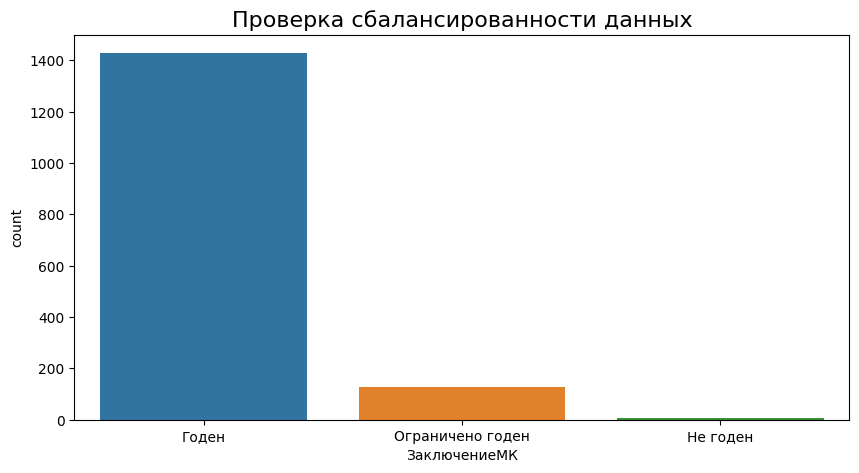

In [32]:
plt.figure(figsize=(10,5))
plt.title('Проверка сбалансированности данных', fontsize=16)
sns.countplot(x=FIELD_CONCLUSION, data=df)

Как видим значения целевой колонки весьма расбалансировано. Мало вероятно, что на этом датасете обучение нейроной сети будет проходить стабильно. Надежда на гораздо больший датасет или же поменьше, но с более равномерным распределением значений для целевой колонки

<Axes: xlabel='КлиентПол', ylabel='count'>

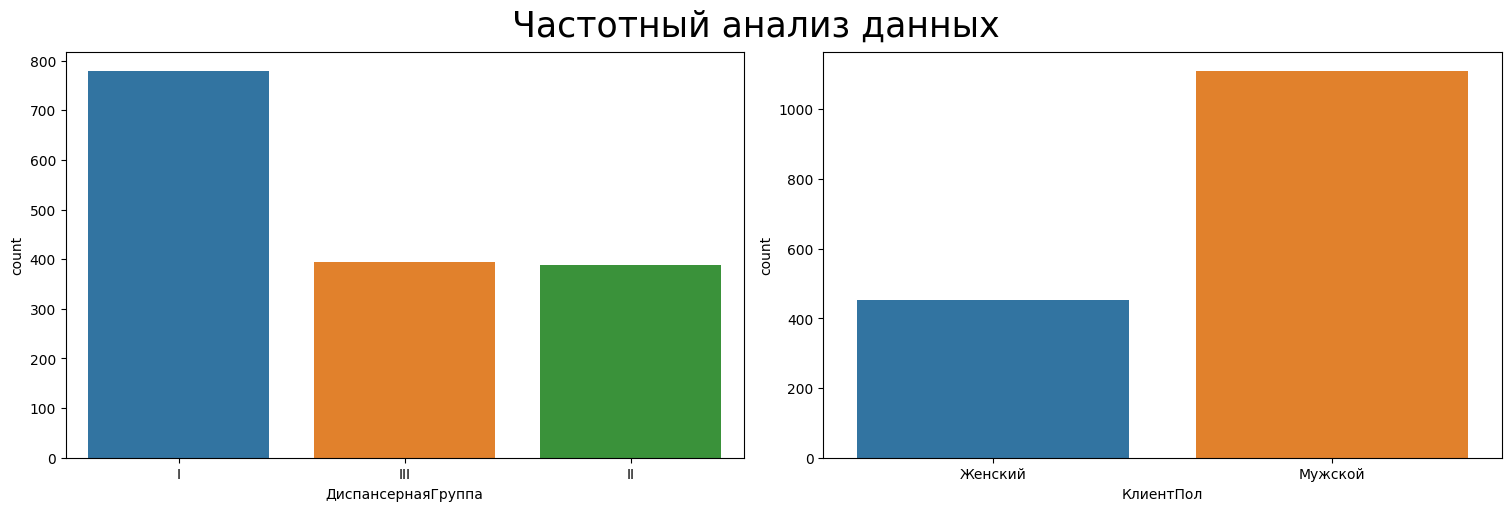

In [33]:
# Задаем параметры полотна
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5), constrained_layout=True)


# Добавляем название графика
fig.suptitle('Частотный анализ данных', fontsize=25)

# Отрисовываем графики по каждому параметру
sns.countplot(x=FIELD_DISPANSARY_GROUP, data=df, ax=ax[0])
sns.countplot(x=FIELD_CLIENT_GENDER, data=df, ax=ax[1])

Колонку возрастов тоже будем преобразовывать на равномерные категории.


Разбиваем возвраста на категории с равномерным процентилем в каждой

In [34]:
age_category_le = AgeCategoryEncoder(5)
df[FIELD_NEW_AGE_CATEGORY] = age_category_le.fit_transform(df[FIELD_CLIENT_AGE])

<ipython-input-34-33bf63703dc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[FIELD_NEW_AGE_CATEGORY] = age_category_le.fit_transform(df[FIELD_CLIENT_AGE])


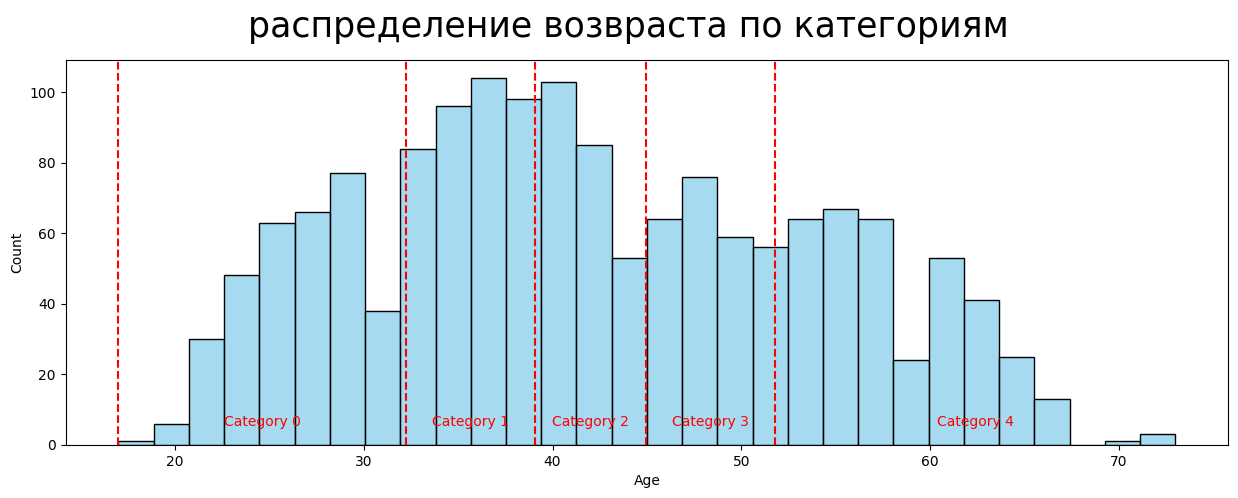

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('распределение возвраста по категориям', fontsize=25)

# Отрисовываем гистограмму
sns.histplot(df[FIELD_CLIENT_AGE], ax=ax, bins=30,  color='skyblue')

# Создаем категории и сразу получаем границы бинов

bins  = age_category_le._classes
bins[0] = df[FIELD_CLIENT_AGE].min()
bins[-1] = df[FIELD_CLIENT_AGE].max()
# Отображаем категории и метки для них
for i in range(len(bins)-1):
    ax.axvline(bins[i], color='red', linestyle='--')
    ax.text((bins[i]+bins[i+1])/2, ax.get_ylim()[1]*0.05, f"Category {i}",
            horizontalalignment='center', color='red')

plt.show()


In [36]:
base_columns = [FIELD_NEW_AGE_CATEGORY, FIELD_CLIENT_GENDER, FIELD_CONCLUSION, FIELD_DISPANSARY_GROUP]
df[base_columns].head()

,ВозрастКатегория,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа
0,3,Женский,Годен,I
1,1,Мужской,Годен,III
2,1,Мужской,Ограничено годен,II
3,1,Мужской,Годен,I
4,1,Мужской,Ограничено годен,II


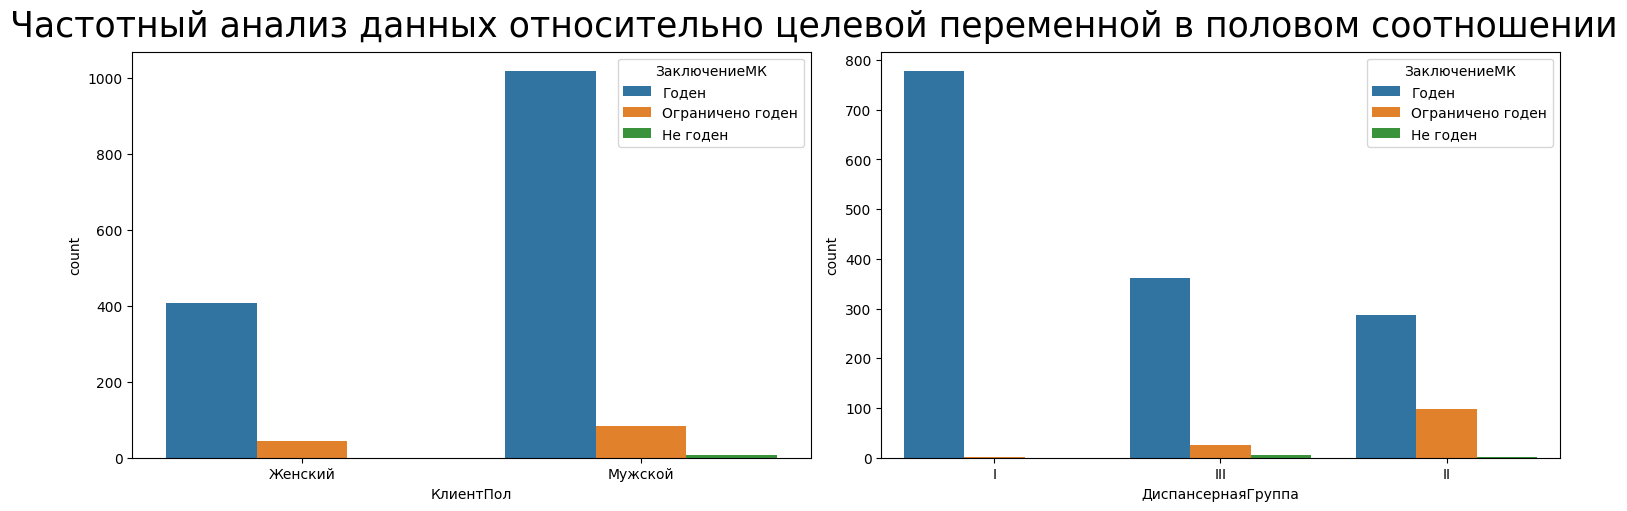

In [37]:
# Задаем параметры полотна
fig, ax = plt.subplots(1,2, sharex=False, sharey=False,figsize=(15,5), constrained_layout=True)

# Добавляем название графика
fig.suptitle('Частотный анализ данных относительно целевой переменной в половом соотношении', fontsize=25)

# Отрисовываем графики по каждому параметру
sns.countplot(x= FIELD_CLIENT_GENDER, hue= FIELD_CONCLUSION,data=df, ax=ax[0])
sns.countplot(x= FIELD_DISPANSARY_GROUP, hue= FIELD_CONCLUSION ,data=df, ax = ax[1])

<Axes: title={'center': 'Частотный анализ возвраста относительно целевой переменной'}, xlabel='Age', ylabel='count'>

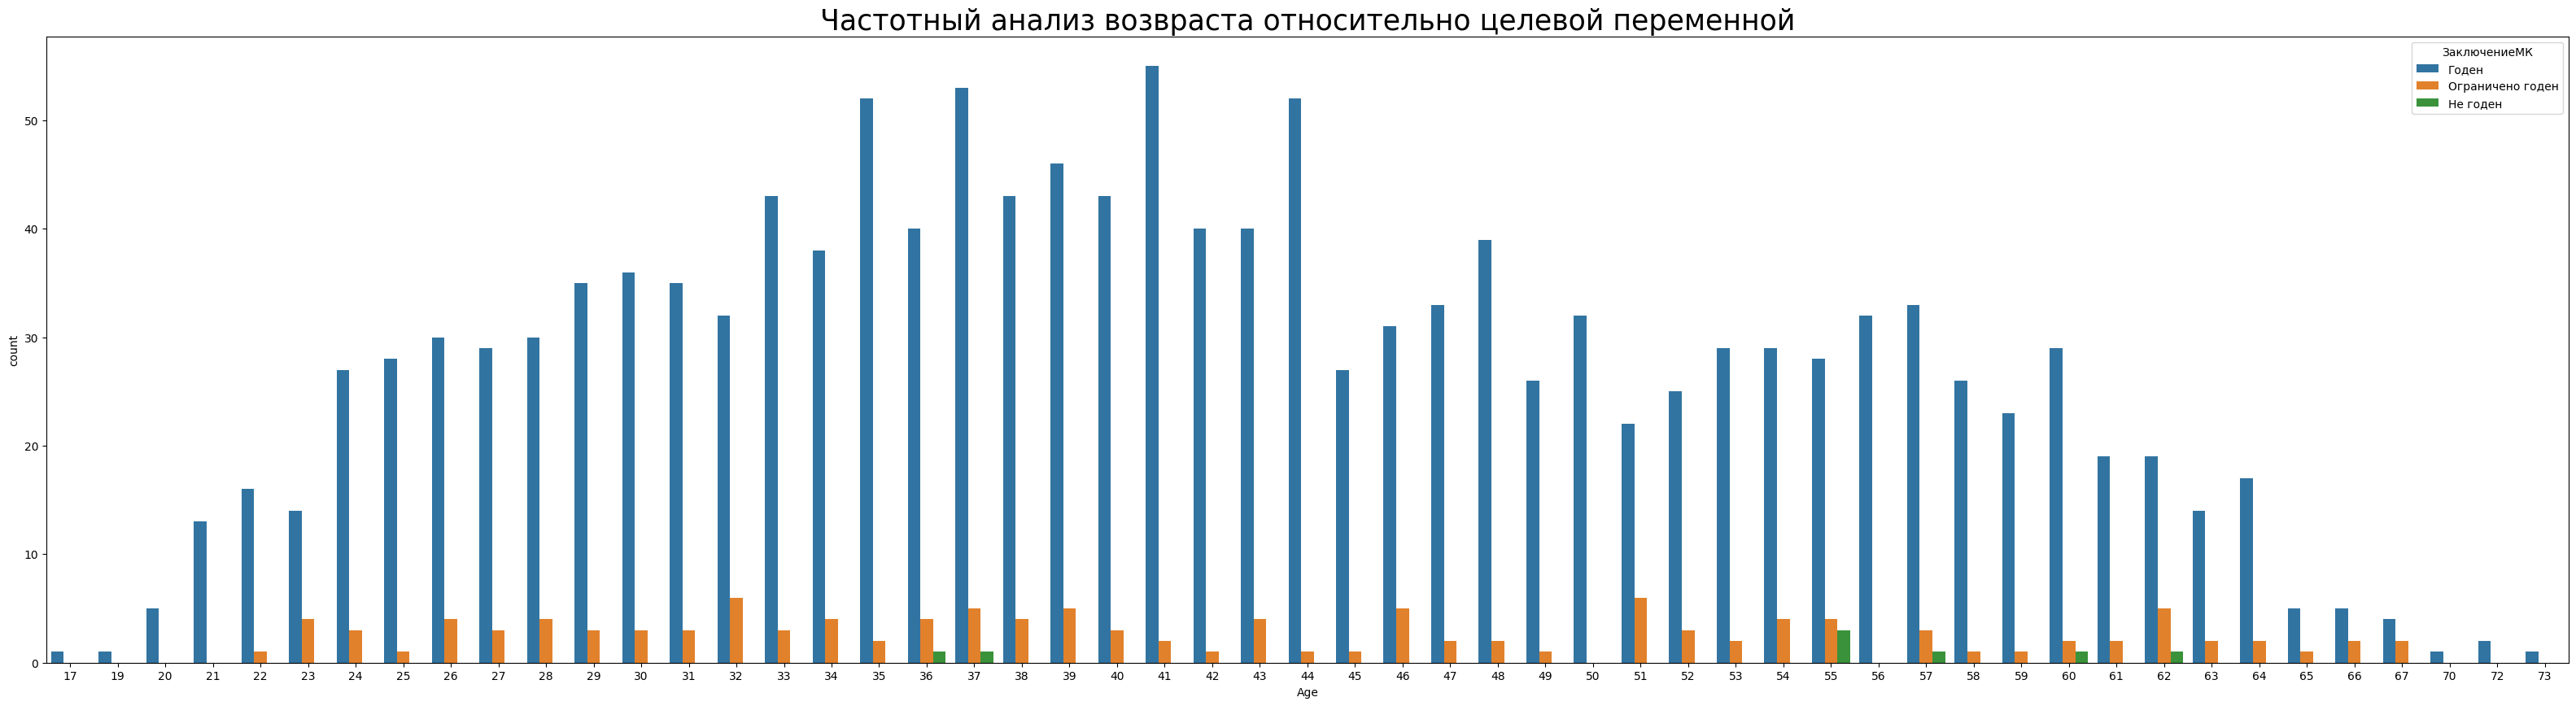

In [38]:
# Задаем размер полотна
plt.figure(figsize=(40,10))

# Добавляем название графика
plt.title('Частотный анализ возвраста относительно целевой переменной', fontsize=25)

# Строим график countplot
sns.countplot(x= FIELD_CLIENT_AGE, hue= FIELD_CONCLUSION, data=df)

# Преобразование категориальных колонок в цифровой вид

In [115]:
df[FIELD_CONCLUSION].unique()

array(['Годен', 'Ограничено годен', 'Не годен'], dtype=object)

In [116]:
conclusion_le = LabelEncoder()
df[FIELD_CONCLUSION_ENCODED] = conclusion_le.fit_transform(df[FIELD_CONCLUSION])
gender_le = LabelEncoder()
df[FIELD_CLIENT_GENDER_ENCODED] = gender_le.fit_transform(df[FIELD_CLIENT_GENDER])
dispansary_le = LabelEncoder()
df[FIELD_DISPANSARY_GROUP_ENCODED] = dispansary_le.fit_transform(df[FIELD_DISPANSARY_GROUP])

In [17]:
categorical_columns = [FIELD_NEW_AGE_CATEGORY, FIELD_CLIENT_GENDER_ENCODED, FIELD_CONCLUSION_ENCODED, FIELD_DISPANSARY_GROUP_ENCODED]

In [39]:
df[categorical_columns].head()

,ВозрастКатегория,Gender,Conclusion,Dispansary Group
0,3,0,1,0
1,1,1,1,2
2,1,1,3,1
3,1,1,1,0
4,1,1,3,1


# Работа с текстовыми и множественными полями

Преобразуем вредные факторы

In [40]:
tokenizer_harmfull = MyTokenizer()
tokenizer_harmfull.process_data(df[FIELD_HARMFUL_FACTORS])
harmful = tokenizer_harmfull.indexed.get_padded()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [41]:
df[FIELD_HARMFUL_FACTORS_ENCODED] = harmful.tolist()

<ipython-input-41-7352e3cda0aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[FIELD_HARMFUL_FACTORS_ENCODED] = harmful.tolist()


In [42]:
df[[FIELD_HARMFUL_FACTORS, FIELD_HARMFUL_FACTORS_ENCODED]]

,ВредныеФакторы,Harful factors
0,11.4,"[6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4.2.5,"[2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4.2.5,"[2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,11.1,"[6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,11.1,"[6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1960,"4.4,4.5,6.1","[2, 2, 2, 4, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1961,"4.4,4.5,6.1","[2, 2, 2, 4, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1962,4.4,"[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1972,3.1.8.2,"[8, 1, 11, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Преобразуем профессию

In [43]:
tokenizer_profession = MyTokenizer()
tokenizer_profession.process_data(df[FIELD_CLIENT_PROFESSION])
df[FIELD_CLIENT_PROFESSION_ENCODED] = tokenizer_profession.indexed.get_padded().tolist()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]
<ipython-input-43-68e9389a65c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[FIELD_CLIENT_PROFESSION_ENCODED] = tokenizer_profession.indexed.get_padded().tolist()


In [44]:
df[[FIELD_CLIENT_PROFESSION, FIELD_CLIENT_PROFESSION_ENCODED]]

,Профессия,Profession
0,Ведущий специалист по организации обуения,"[5, 4, 2, 188, 308, 0, 0, 0, 0, 0, 0, 0]"
1,Ведущий специалист,"[5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Главный менеджер,"[15, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Главный специалист,"[15, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Старший специалист,"[9, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
1960,Инженер,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1961,Инженер,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1962,Начальник лаборатории,"[11, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1972,"Инженер по бурению 1 категории, непосредственн...","[1, 2, 114, 24, 10, 512, 293, 195, 513, 0, 0, 0]"


## Объединяем все mkb колонки в одну

In [45]:
mkbs_filter = df.filter(regex="(?i)МКБ10")
df[FIELD_NEW_MKBS] = join_not_nan_columns(df, mkbs_filter, value_for_unset="Z00.0")
df = df.drop(columns=mkbs_filter)

<ipython-input-10-c5778d593a70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)
<ipython-input-10-c5778d593a70>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)
<ipython-input-45-6ecd75b5f5b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [46]:
tokenizer_mkb = MyTokenizer( filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0')
tokenizer_mkb.process_data(df[FIELD_NEW_MKBS])
df[FIELD_NEW_MKBS_ENCODED]  =  tokenizer_mkb.indexed.get_padded().tolist()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [47]:
df[[FIELD_NEW_MKBS, FIELD_NEW_MKBS_ENCODED]]

,mkbs,mkbs_encoded
0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Терапия I11.9,"[2, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Офтальмология H52.1,"[1, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Офтальмология H52.2,"[1, 3, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1960,Офтальмология H52.1,"[1, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1961,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1962,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1972,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Объединяем диагнозы в одну колонку

In [48]:
diag_filter = df.filter(regex="(?i)Диагноз\s?Представление")
df[FIELD_NEW_CLIENT_DIAG] =  join_not_nan_columns(df, diag_filter, value_for_unset="Общий медицинский осмотр")
#Удаляю ненужные колонки
df = df.drop(columns=diag_filter)

<ipython-input-10-c5778d593a70>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)


In [49]:
tokenizer_diag = MyTokenizer()
tokenizer_diag.process_data(df[FIELD_NEW_CLIENT_DIAG])
df[FIELD_NEW_CLIENT_DIAG_ENCODED] = tokenizer_diag.indexed.get_padded().tolist()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [50]:
df[[FIELD_NEW_CLIENT_DIAG, FIELD_NEW_CLIENT_DIAG_ENCODED]]

,Diagnoz,Diagnoz Encoded
0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Терапия Гипертензивная [гипертоническая] болез...,"[2, 7, 8, 4, 5, 9, 10, 6, 3, 11, 12, 13, 0, 0,..."
2,Офтальмология Миопия,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Офтальмология Астигматизм,"[1, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
1960,Офтальмология Миопия,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1961,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1962,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1972,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Объединяем все дополнения в одну колонку

In [51]:
additions_filter = df.filter(regex="(?i)Дополнение_Значение$")
df[FIELD_NEW_CLIENT_ADDITIONS] = join_not_nan_columns(df, additions_filter)
df = df.drop(columns=additions_filter)

In [52]:
tokenizer_additions = MyTokenizer(num_words=1000, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_additions.process_data(df[FIELD_NEW_CLIENT_ADDITIONS])
df[FIELD_NEW_CLIENT_ADDITIONS_ENCODED]  = tokenizer_additions.indexed.get_padded().tolist()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [53]:
df[[FIELD_NEW_CLIENT_ADDITIONS, FIELD_NEW_CLIENT_ADDITIONS_ENCODED]]

,Дополнения сводные,Дополнения сводные encoded
0,"Эндоскопия Дискинезия желчевыводящих путей ,Те...","[23, 137, 138, 139, 19, 664, 0, 0, 0, 0, 0, 0,..."
1,Терапия В анамнезе ГБ,"[19, 5, 391, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,"Терапия карбомезипин,мексидол,Офтальмология но...","[19, 665, 481, 3, 33, 34, 26, 21, 26, 22, 3, 4..."
3,Эндоскопия Патологии со стороны слизистой пище...,"[23, 31, 42, 44, 40, 43, 38, 6, 36, 41, 37, 27..."
4,"Эндоскопия Без патологии.,Офтальмология носит ...","[23, 58, 31, 3, 33, 34, 77, 48, 32, 168, 235, ..."
...,...,...
1960,"Офтальмология 1,0,Офтальмология -0,75 -0,50/-0,50","[3, 4, 2, 3, 2, 24, 2, 21, 2, 21, 0, 0, 0, 0, ..."
1961,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1962,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1972,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Данные

In [80]:
categorical_columns = [FIELD_NEW_AGE_CATEGORY, FIELD_CLIENT_GENDER_ENCODED, FIELD_DISPANSARY_GROUP_ENCODED]

In [120]:
Y_CLASSES = len(conclusion_le.classes_)

In [122]:
x_train_ohe, x_test_ohe,  \
x_train_mkb, x_test_mkb, \
x_train_prof, x_test_prof, \
x_train_harm, x_test_harm, \
x_train_additions, x_test_additions, \
x_train_diag, x_test_diag, \
y_train, y_test = train_test_split(pd.get_dummies(df[categorical_columns],  columns = categorical_columns).values,
                                   tokenizer_mkb.indexed.get_padded(),
                                   tokenizer_profession.indexed.get_padded(),
                                   tokenizer_harmfull.indexed.get_padded(),
                                   tokenizer_additions.indexed.get_padded(),
                                   tokenizer_diag.indexed.get_padded(),
                                   pd.get_dummies(df[FIELD_CONCLUSION]).values,
                                   test_size=0.2, shuffle = False)

# Модель 1

In [123]:
# На этот вход подаются все OHE
input_ohe = Input((x_train_ohe.shape[1], ), name="OHE")
# Сюда подаются mkb в виде последовательности токенов , поскольку они уже объединины в одой колонке
input_mkb = Input((x_train_mkb.shape[1],), name="MKB")
# Сюда подаются вредные факторы тоже аналогично мкб , как будто это предложение из токенов
input_harmfull = Input((x_train_harm.shape[1],), name="harm")
# Сюда подаются профессии , тоже как предложение токенов
input_prof = Input((x_train_prof.shape[1],), name="prof")
# Дополнения от специалистов
input_additions = Input((x_train_additions.shape[1],), name="additions")
# Диагнозы от специалистов (текст)
input_diag = Input((x_train_diag.shape[1],), name="diag")

In [152]:
def f1_score_keras(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Округление предсказанных значений до 0 или 1
    return skl_metrics.f1_score(y_true, y_pred)

f1score = tfad.metrics.F1Score(num_classes=Y_CLASSES)

## Функция модели

In [146]:
def create_model1(input_ohe, input_mkb, input_harmfull, input_prof, num_classes = Y_CLASSES):
  x0 = BatchNormalization()(input_ohe)
  x0 = Dense(1024, activation='relu') (x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(768, activation='sigmoid')(x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(512, activation='sigmoid')(x0)

  x1 = Embedding(tokenizer_mkb.vocab_size, 128,  input_length = tokenizer_mkb.indexed.max_len)(input_mkb)
  x1 = SpatialDropout1D(0.2)(x1)
  x1 = Dense(100, activation = 'sigmoid')(x1)
  #x1 = Flatten()(x1)

  x2 = Embedding(tokenizer_harmfull.vocab_size, 128, input_length = tokenizer_harmfull.indexed.max_len)(input_harmfull)
  x2 = SpatialDropout1D(0.2)(x2)
  x2 = Dense(100, activation = 'sigmoid')(x2)
  #x2 = Flatten()(x2)

 # x3 = Embedding(prof_vocab_size, 256, input_length = prof_max_len)(input_prof)
 # x3 = SpatialDropout1D(0.2)(x3)
  x3 = Dense(100, activation = 'sigmoid')(input_prof)
  x3 = Reshape((1, 100))(x3)

  #x3 = Flatten()(x3)

  x_ = concatenate([x1, x2, x3], axis = -2)
  x_ = Flatten()(x_)
  x = concatenate([x0, x_])


  x = Dense(800, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(num_classes, activation='softmax')(x)

  return Model((input_ohe, input_mkb, input_harmfull, input_prof), x )

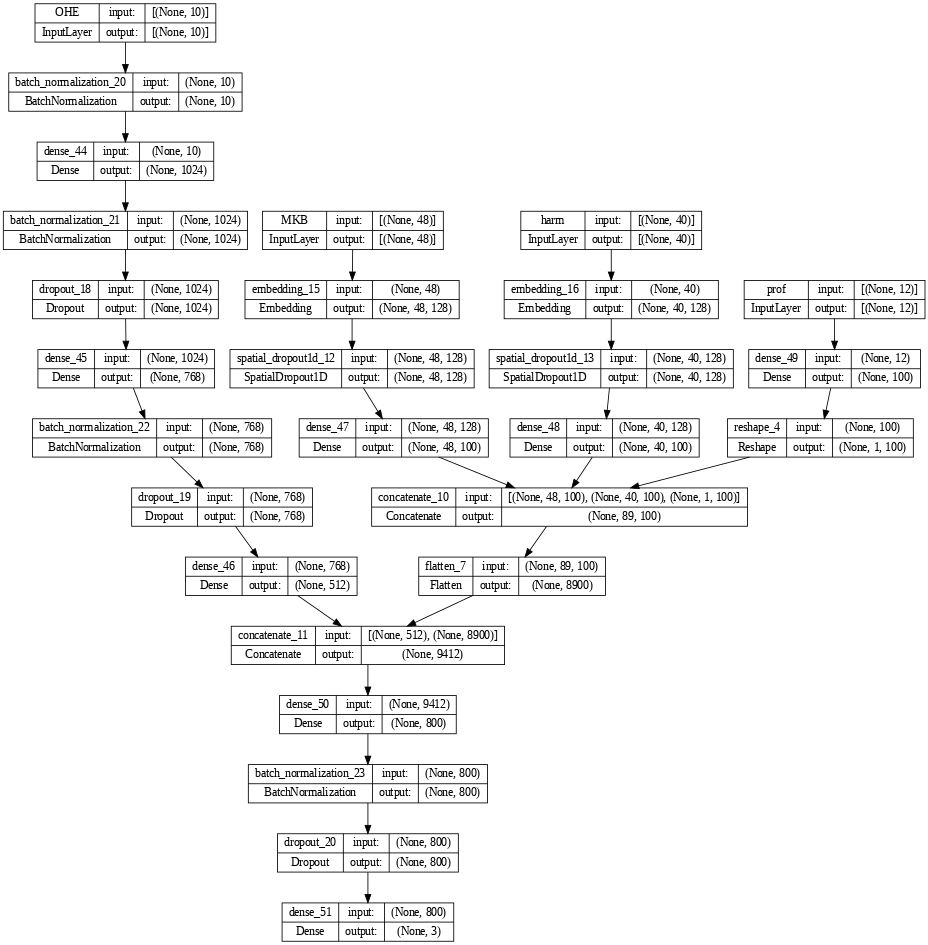

In [147]:
model1 = create_model1(input_ohe, input_mkb, input_harmfull, input_prof)
utils.plot_model(model1, dpi=60, show_shapes = True)


In [148]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/prof_patolog/model1.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [149]:
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.9999, epsilon=1e-08) #кастомизируем оптимизатор под наши цели

In [153]:
model1.compile(optimizer = opt, loss = keras_losses.categorical_crossentropy, metrics=[f1score, 'Recall', 'accuracy'])

In [154]:
history = model1.fit((x_train_ohe,
                     x_train_mkb,
                     x_train_harm,
                     x_train_prof),
                     y_train,
                     batch_size=60,
                     epochs=50,
                     validation_split=0.15,
                     verbose=1, callbacks=checkpoint, shuffle=True)

Epoch 1/50
15/18 [========================>.....] - ETA: 0s - loss: 0.0953 - f1_score: 0.8706 - recall: 0.9689 - accuracy: 0.9689
Epoch 1: val_accuracy did not improve from 0.90957
18/18 [==============================] - 3s 39ms/step - loss: 0.1001 - f1_score: 0.8357 - recall: 0.9632 - accuracy: 0.9632 - val_loss: 2.0593 - val_f1_score: 0.3175 - val_recall: 0.9096 - val_accuracy: 0.9096
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0942 - f1_score: 0.8525 - recall: 0.9598 - accuracy: 0.9598
Epoch 2: val_accuracy did not improve from 0.90957
18/18 [==============================] - 0s 16ms/step - loss: 0.0957 - f1_score: 0.8512 - recall: 0.9595 - accuracy: 0.9595 - val_loss: 0.3529 - val_f1_score: 0.3706 - val_recall: 0.8617 - val_accuracy: 0.8617
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.1061 - f1_score: 0.8199 - recall: 0.9566 - accuracy: 0.9566
Epoch 3: val_accuracy did not improve from 0.90957
18/18 [==============================

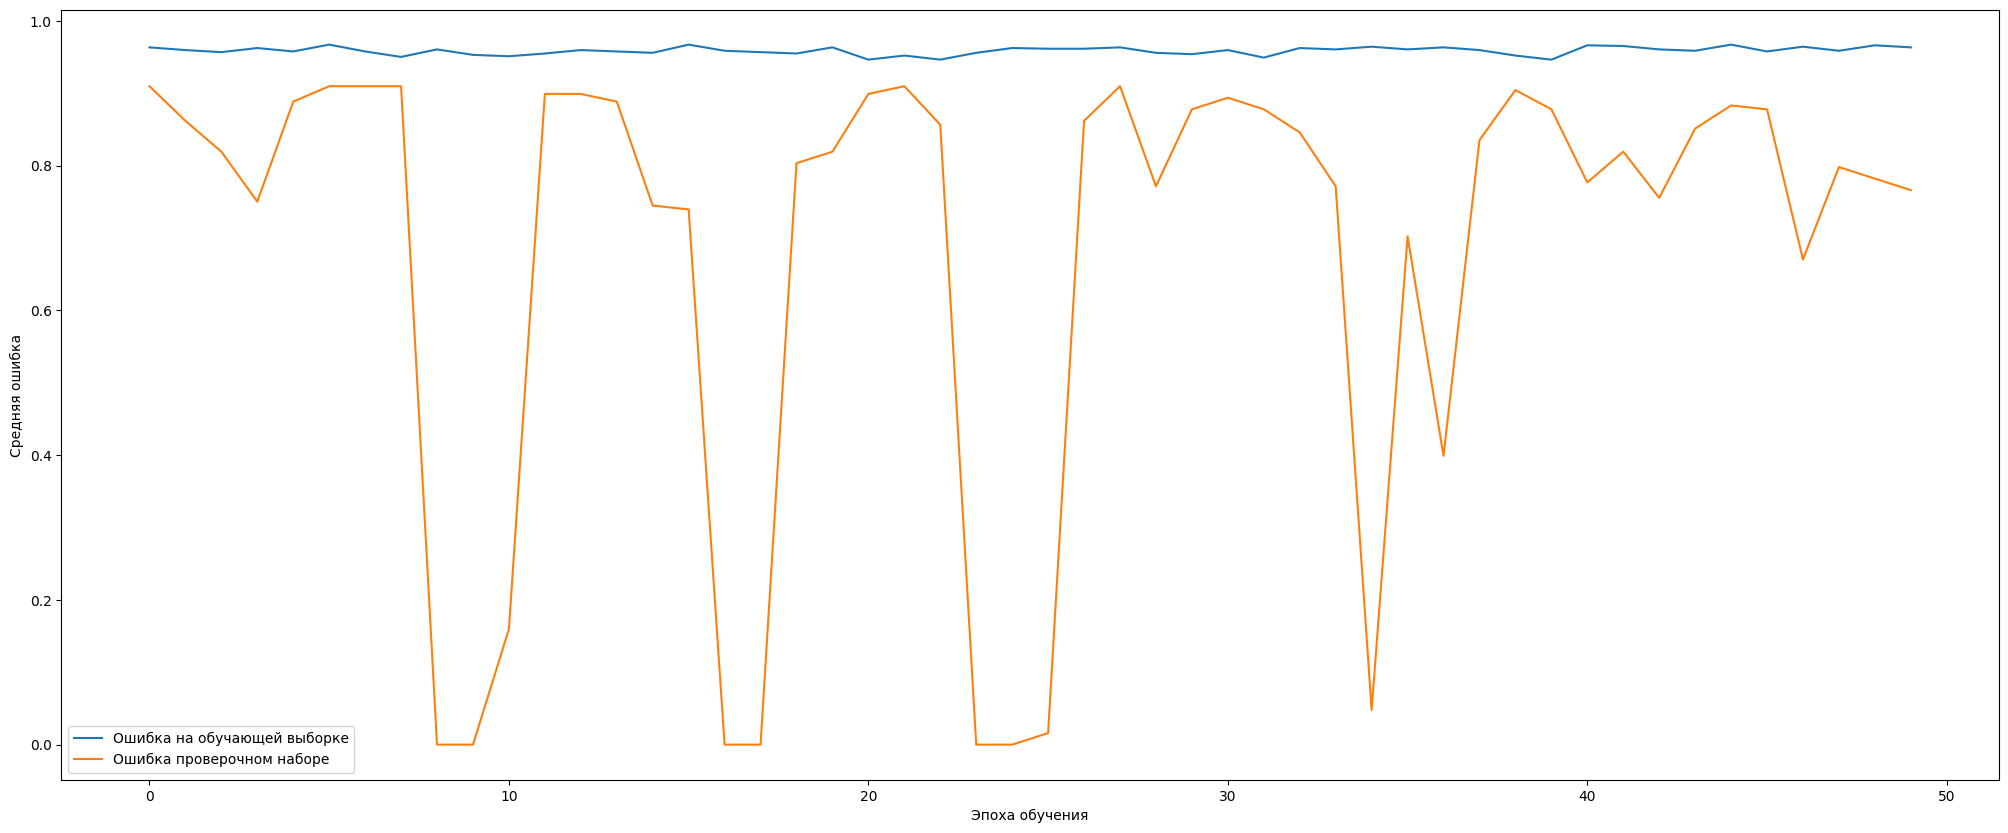

In [155]:
compare_sharp_loss(history, target = 'accuracy')

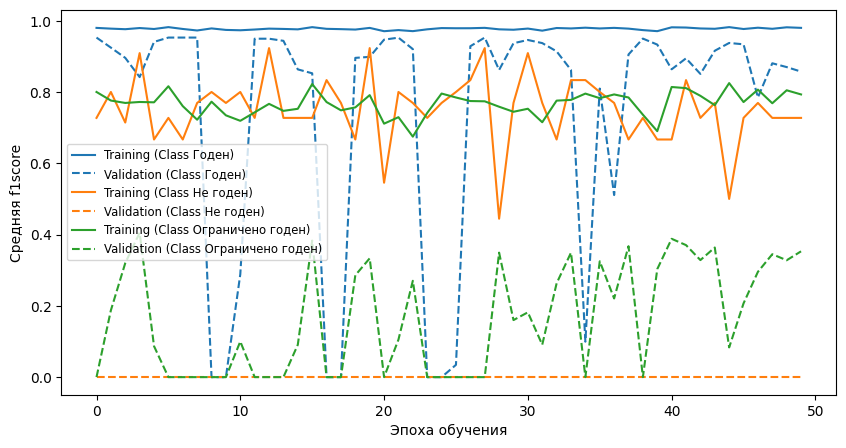

In [156]:
compare_f1_score(history, conclusion_le)

10/10 [==============================] - 0s 4ms/step


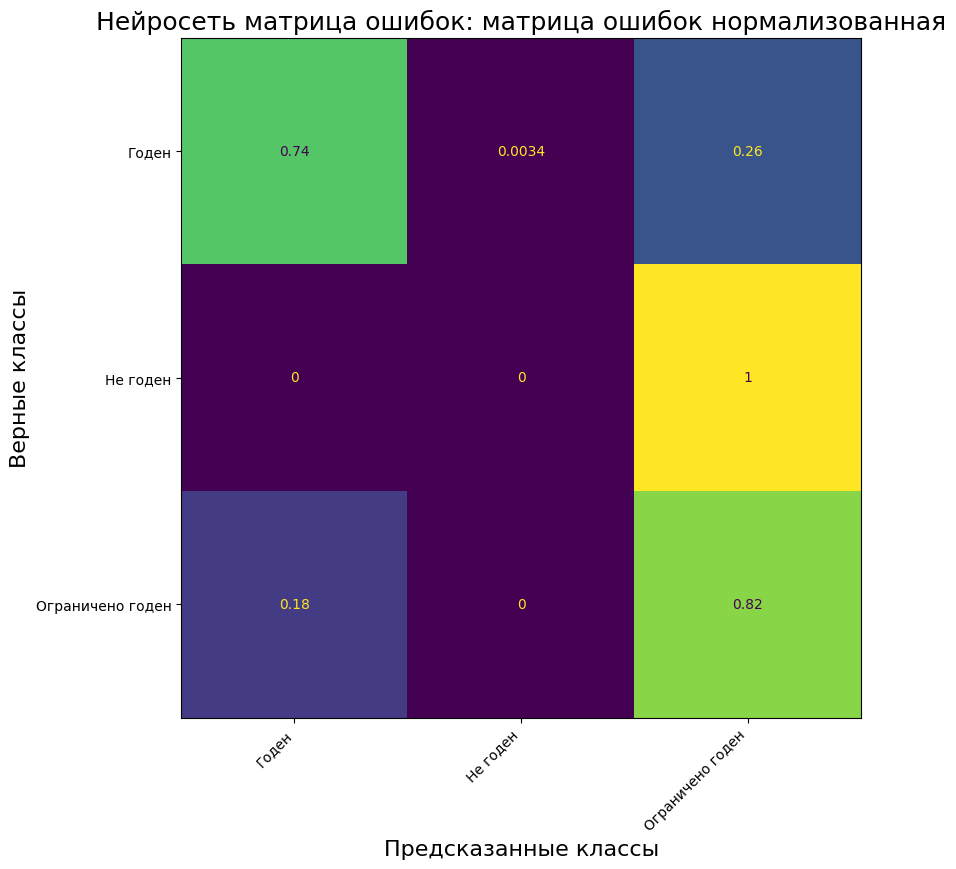

In [161]:
model_evaluate(model1.predict((x_test_ohe,x_test_mkb, x_test_harm, x_test_prof)),
              y_test)

# Model 2

In [132]:
def create_model2(input_ohe, input_mkb, input_harmfull, input_prof, input_additions):
  x0 = BatchNormalization()(input_ohe)
  x0 = Dense(1024, activation='relu') (x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(768, activation='sigmoid')(x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(512, activation='sigmoid')(x0)

  x1 = Embedding(tokenizer_mkb.vocab_size, 128, input_length = tokenizer_mkb.indexed.max_len)(input_mkb)
  x1 = SpatialDropout1D(0.2)(x1)
  x1 = Conv1D(128,3, activation = 'relu', padding='same')(x1)
  x1 = GlobalMaxPooling1D()(x1)
  x1 = Dense(256, activation = 'sigmoid')(x1)
  #x1 = Flatten()(x1)

  x2 = Embedding(tokenizer_harmfull.vocab_size, 128, input_length = tokenizer_harmfull.indexed.max_len)(input_harmfull)
  x2 = SpatialDropout1D(0.2)(x2)
  x2 = Conv1D(128,3, activation = 'relu', padding='same')(x2)
  x2 = GlobalMaxPooling1D()(x2)
  x2 = Dense(256, activation = 'relu')(x2)
  #x2 = Flatten()(x2)

  x3 = Embedding(tokenizer_profession.vocab_size, 256, input_length = tokenizer_profession.indexed.max_len)(input_prof)
  x3 = SpatialDropout1D(0.2)(x3)
  x3 = Conv1D(128,2, activation = 'relu', padding='same')(x3)
  x3 = GlobalMaxPooling1D()(x3)
  x3 = Dense(256, activation = 'relu')(x3)
  #x3 = Flatten()(x3)

  x4 = Embedding(tokenizer_additions.vocab_size, 256, input_length = tokenizer_additions.indexed.max_len)(input_additions)
  x4 = SpatialDropout1D(0.2)(x4)
  x4 = Conv1D(128,2, activation = 'relu', padding='same')(x4)
  x4 = GlobalMaxPooling1D()(x4)
  x4 = Dense(256, activation = 'relu')(x4)
  #x3 = Flatten()(x3)

  x = concatenate([x0,x1, x2, x3, x4])
  x = Dense(800, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(Y_CLASSES, activation='softmax')(x)

  model =  Model((input_ohe, input_mkb, input_harmfull, input_prof, input_additions), x )
  opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.9999, epsilon=1e-08) #кастомизируем оптимизатор под наши цели
  model.compile(optimizer = opt, loss = keras_losses.mse, metrics=['accuracy', keras_metrics.mae, f1score, 'Recall'])
  return model

In [133]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/prof_patolog/model2.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [134]:
model2 = create_model2(input_ohe, input_mkb, input_harmfull, input_prof, input_additions)

In [135]:
history = model2.fit((x_train_ohe,
                     x_train_mkb,
                     x_train_harm,
                     x_train_prof,
                     x_train_additions),
                     y_train,
                     batch_size=60,
                     epochs=50,
                     validation_split=0.15,
                     verbose=1, callbacks=checkpoint, shuffle=True)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.6296 - mean_absolute_error: 0.2488 - f1_score: 0.3502 - recall: 0.6258
Epoch 1: val_accuracy improved from -inf to 0.68085, saving model to /content/drive/MyDrive/prof_patolog/model2.h5
18/18 [==============================] - 22s 730ms/step - loss: 0.2188 - accuracy: 0.6296 - mean_absolute_error: 0.2488 - f1_score: 0.3502 - recall: 0.6258 - val_loss: 0.1878 - val_accuracy: 0.6809 - val_mean_absolute_error: 0.2108 - val_f1_score: 0.2826 - val_recall: 0.6809
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.7069 - mean_absolute_error: 0.1996 - f1_score: 0.3973 - recall: 0.7050
Epoch 2: val_accuracy improved from 0.68085 to 0.80851, saving model to /content/drive/MyDrive/prof_patolog/model2.h5
18/18 [==============================] - 7s 365ms/step - loss: 0.1662 - accuracy: 0.7069 - mean_absolute_error: 0.1996 - f1_score: 0.3973 - recall: 0.7050 - val_loss: 0.12

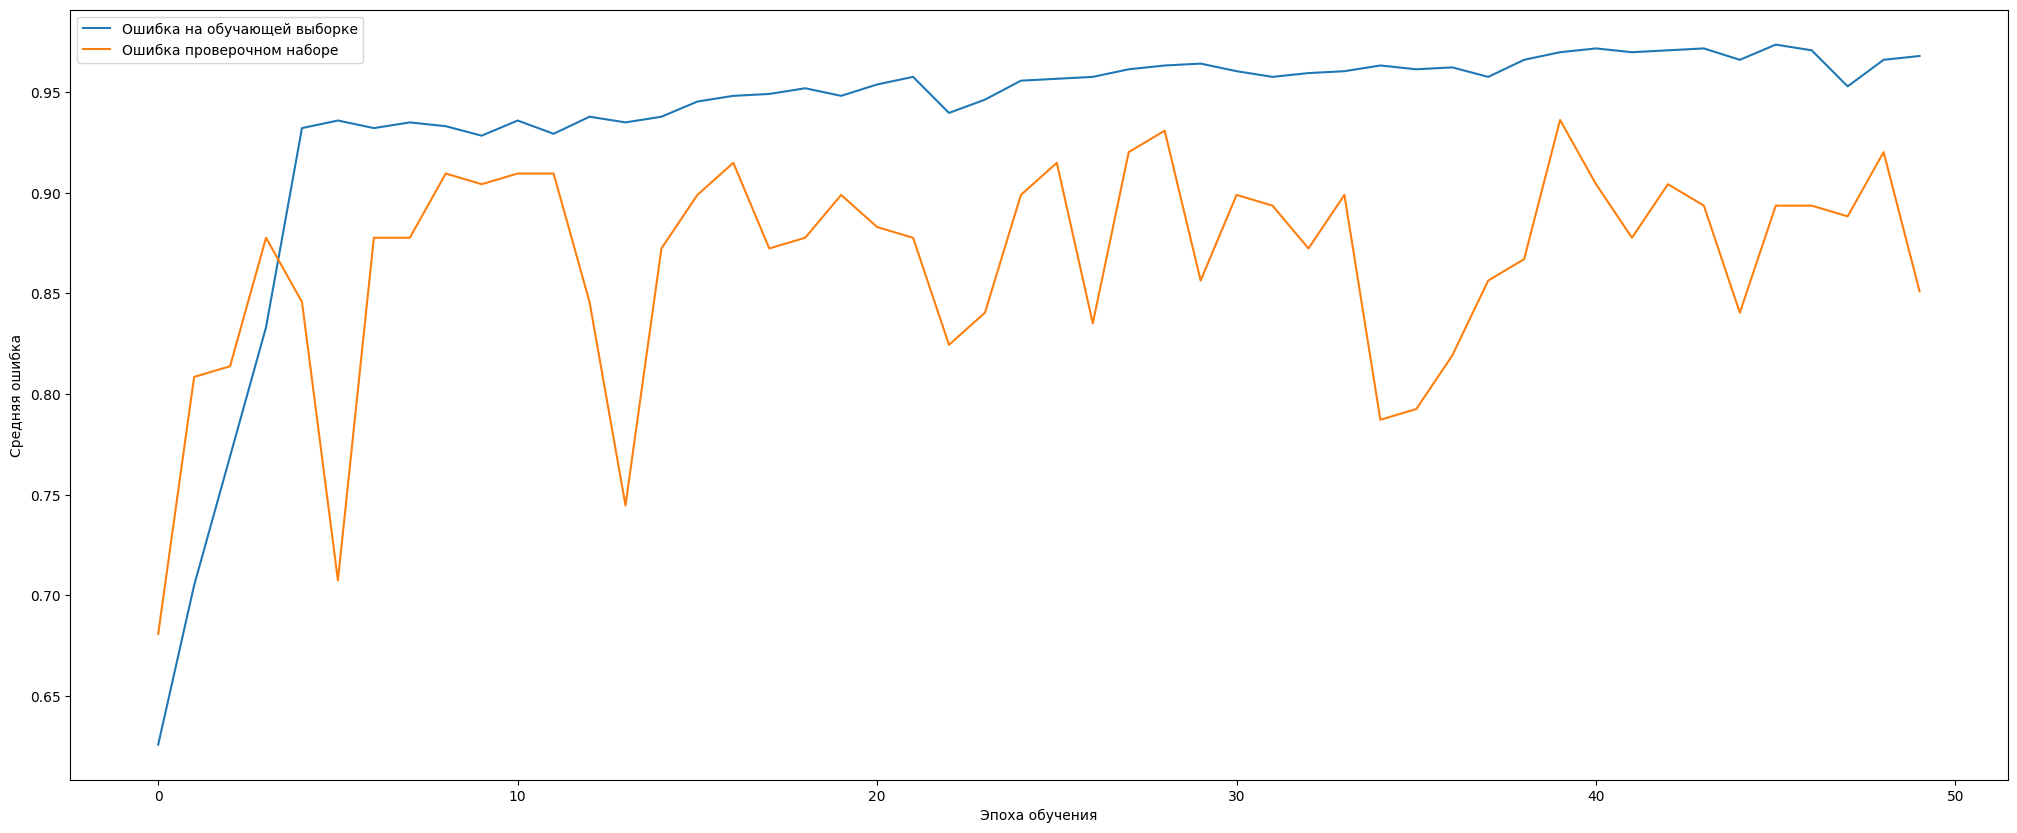

In [136]:
compare_sharp_loss(history, target = 'recall')

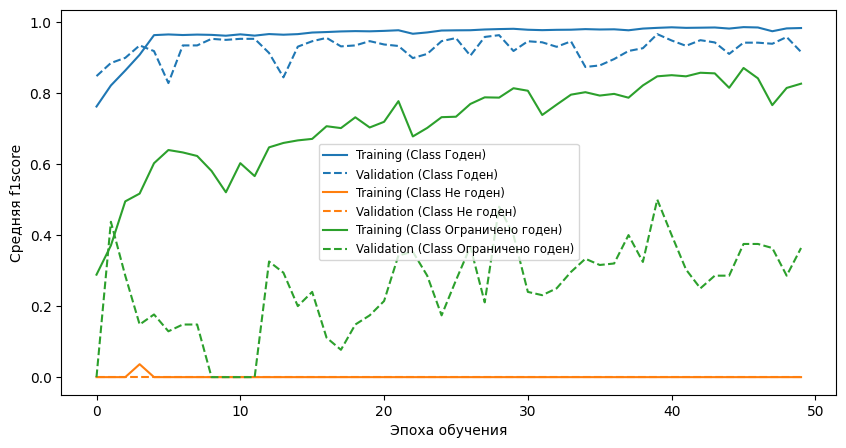

In [145]:
compare_f1_score(history, conclusion_le)

10/10 [==============================] - 0s 4ms/step


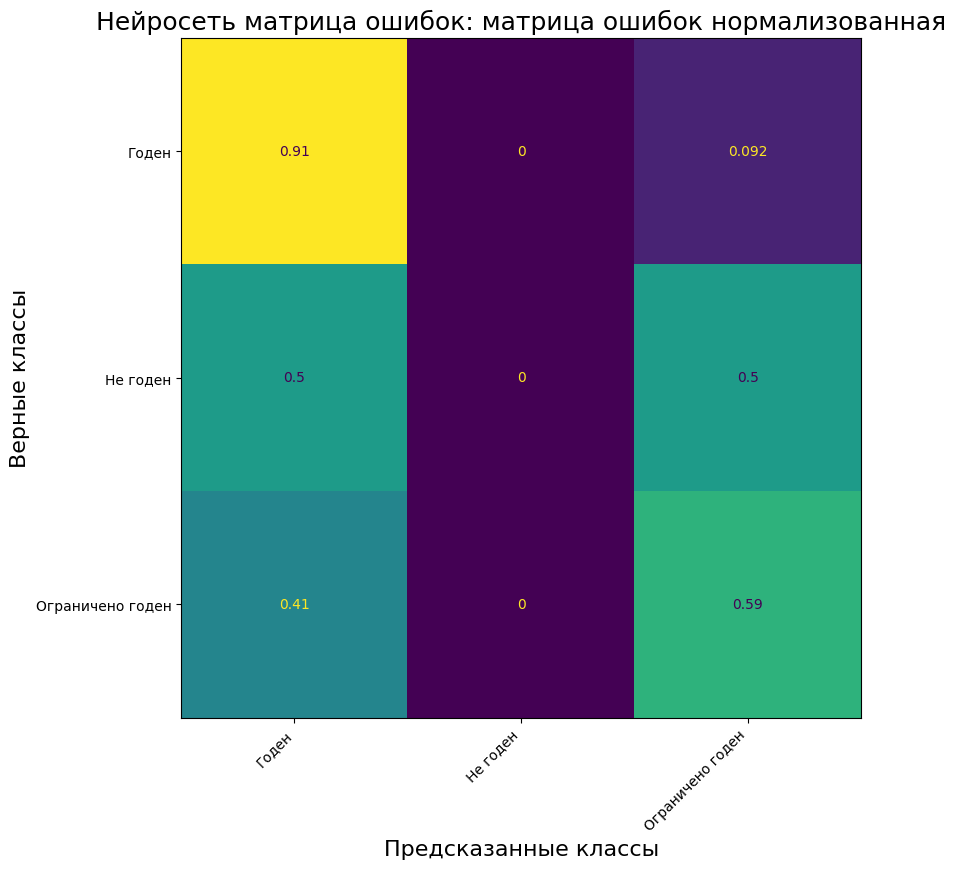

In [158]:
model_evaluate(
    model2.predict((x_test_ohe, x_test_mkb, x_test_harm, x_test_prof, x_test_additions)),
    y_test
)

# Эксперимент с автокерасом

In [164]:
categorical_columns = [FIELD_NEW_AGE_CATEGORY, FIELD_CLIENT_GENDER_ENCODED, FIELD_DISPANSARY_GROUP_ENCODED]

In [165]:
x_train_categorical, x_test_categorical,  \
x_train_prof, x_test_prof, \
x_train_additions, x_test_additions, \
x_train_diag, x_test_diag, \
y_train, y_test = train_test_split(pd.get_dummies(df[categorical_columns],  columns = categorical_columns).values,
                                   df[FIELD_CLIENT_PROFESSION].to_numpy(),
                                   df[[FIELD_NEW_CLIENT_ADDITIONS]].to_numpy(),
                                   df[[FIELD_NEW_CLIENT_DIAG]].to_numpy(),
                                   pd.get_dummies(df[FIELD_CONCLUSION]).values,
                                   test_size=0.2, shuffle = False)

In [167]:
from sys import meta_path
# создаем входной узел для структурированных данных
x_base_input = ak.StructuredDataInput(name = 'base')
x_base_output = ak.StructuredDataBlock()(x_base_input)

# создаем входной узел для текстовых данных
x_prof_input = ak.TextInput(name="prof")
x_prof_output = ak.TextToIntSequence()(x_prof_input)
x_prof_output = ak.Embedding()(x_prof_output)
x_prof_output = ak.ConvBlock(separable=True)(x_prof_output)

x_harm_input = ak.TextInput(name="harm")
x_harm_output = ak.TextToIntSequence()(x_harm_input)
x_harm_output = ak.Embedding()(x_harm_output)
x_harm_output = ak.ConvBlock(separable=True)(x_harm_output)

x_additions_input = ak.TextInput(name="additions")
x_additions_output = ak.TextToIntSequence()(x_additions_input)
x_additions_output = ak.Embedding()(x_additions_output)
x_additions_output = ak.ConvBlock(separable=True)(x_additions_output)


x_diags_input = ak.TextInput(name="diags")
x_diags_output = ak.TextToIntSequence()(x_diags_input)
x_diags_output = ak.Embedding()(x_diags_output)
x_diags_output = ak.ConvBlock(separable=True)(x_diags_output)
# объединяем оба выхода
merged_output = ak.Merge()([x_base_output,
                            x_prof_output,
                            x_additions_output,
                            x_diags_output
                            ])

# добавляем выходной узел для классификации
output_node = ak.ClassificationHead(num_classes=Y_CLASSES)(merged_output)

# создаем и обучаем автомодель
auto_model = ak.AutoModel(
    inputs=[
      x_base_input,
      x_prof_input,
      x_additions_input,
      x_diags_input
      ],
    outputs=output_node,
    overwrite=True,
    max_trials=10,
    executions_per_trial = 3, # запуск одной архитектуры для подбора первоначальных весов
    #metrics=[keras_metrics.mae, f1score]
)


history = auto_model.fit([
      x_train_categorical,
      x_train_prof,
      x_train_additions,
      x_train_diag
    ]
    , y_train,
    epochs=5,
    validation_split=0.3
    )

Trial 3 Complete [00h 00m 45s]
val_loss: 0.26820945739746094

Best val_loss So Far: 0.26820945739746094
Total elapsed time: 00h 02m 16s
Epoch 1/10
40/40 [==============================] - 23s 378ms/step - loss: 0.5490 - accuracy: 0.8999
Epoch 2/10
40/40 [==============================] - 1s 19ms/step - loss: 0.3455 - accuracy: 0.9079
Epoch 3/10
40/40 [==============================] - 1s 20ms/step - loss: 0.3297 - accuracy: 0.9079
Epoch 4/10
40/40 [==============================] - 1s 24ms/step - loss: 0.3184 - accuracy: 0.9079
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 0.3050 - accuracy: 0.9079
Epoch 6/10
40/40 [==============================] - 1s 17ms/step - loss: 0.2905 - accuracy: 0.9079
Epoch 7/10
40/40 [==============================] - 1s 18ms/step - loss: 0.2773 - accuracy: 0.9079
Epoch 8/10
40/40 [==============================] - 1s 18ms/step - loss: 0.2672 - accuracy: 0.9079
Epoch 9/10
40/40 [==============================] - 1s 18ms/step - los

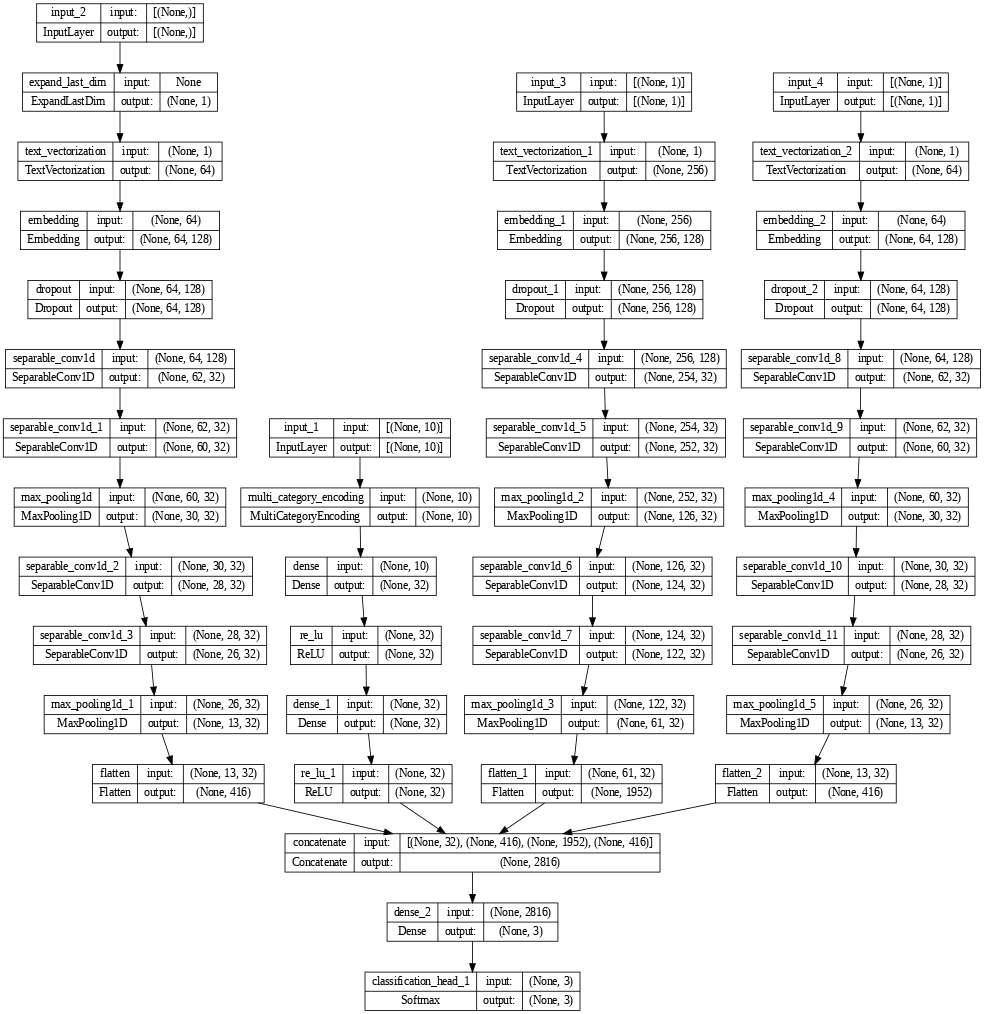

In [168]:
best_model = auto_model.export_model()
utils.plot_model(best_model, dpi=60, show_shapes = True,show_layer_names=True)

In [169]:
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.9999, epsilon=1e-08) #кастомизируем оптимизатор под наши цели
best_model.compile(optimizer = opt, loss = keras_losses.mse, metrics=['accuracy', keras_metrics.mae, f1score, 'Recall'])


In [170]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/prof_patolog/best_automodel.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [171]:
history = best_model.fit([
                x_train_categorical,
                x_train_prof,
                x_train_additions,
                x_train_diag
               ],
                y_train,
                batch_size=60,
                epochs=50,
                validation_split=0.15,
                verbose=1, shuffle=True)

Epoch 1/50
18/18 [==============================] - 25s 669ms/step - loss: 0.0569 - accuracy: 0.9076 - mean_absolute_error: 0.0736 - f1_score: 0.3732 - recall: 0.9048 - val_loss: 0.0586 - val_accuracy: 0.9096 - val_mean_absolute_error: 0.0620 - val_f1_score: 0.3175 - val_recall: 0.9096
Epoch 2/50
18/18 [==============================] - 9s 507ms/step - loss: 0.0532 - accuracy: 0.9076 - mean_absolute_error: 0.0964 - f1_score: 0.3172 - recall: 0.9076 - val_loss: 0.0442 - val_accuracy: 0.9096 - val_mean_absolute_error: 0.0960 - val_f1_score: 0.3175 - val_recall: 0.9096
Epoch 3/50
18/18 [==============================] - 7s 359ms/step - loss: 0.0497 - accuracy: 0.9057 - mean_absolute_error: 0.0983 - f1_score: 0.3168 - recall: 0.9048 - val_loss: 0.0521 - val_accuracy: 0.8670 - val_mean_absolute_error: 0.1330 - val_f1_score: 0.3737 - val_recall: 0.8670
Epoch 4/50
18/18 [==============================] - 8s 422ms/step - loss: 0.0497 - accuracy: 0.9048 - mean_absolute_error: 0.1004 - f1_score:

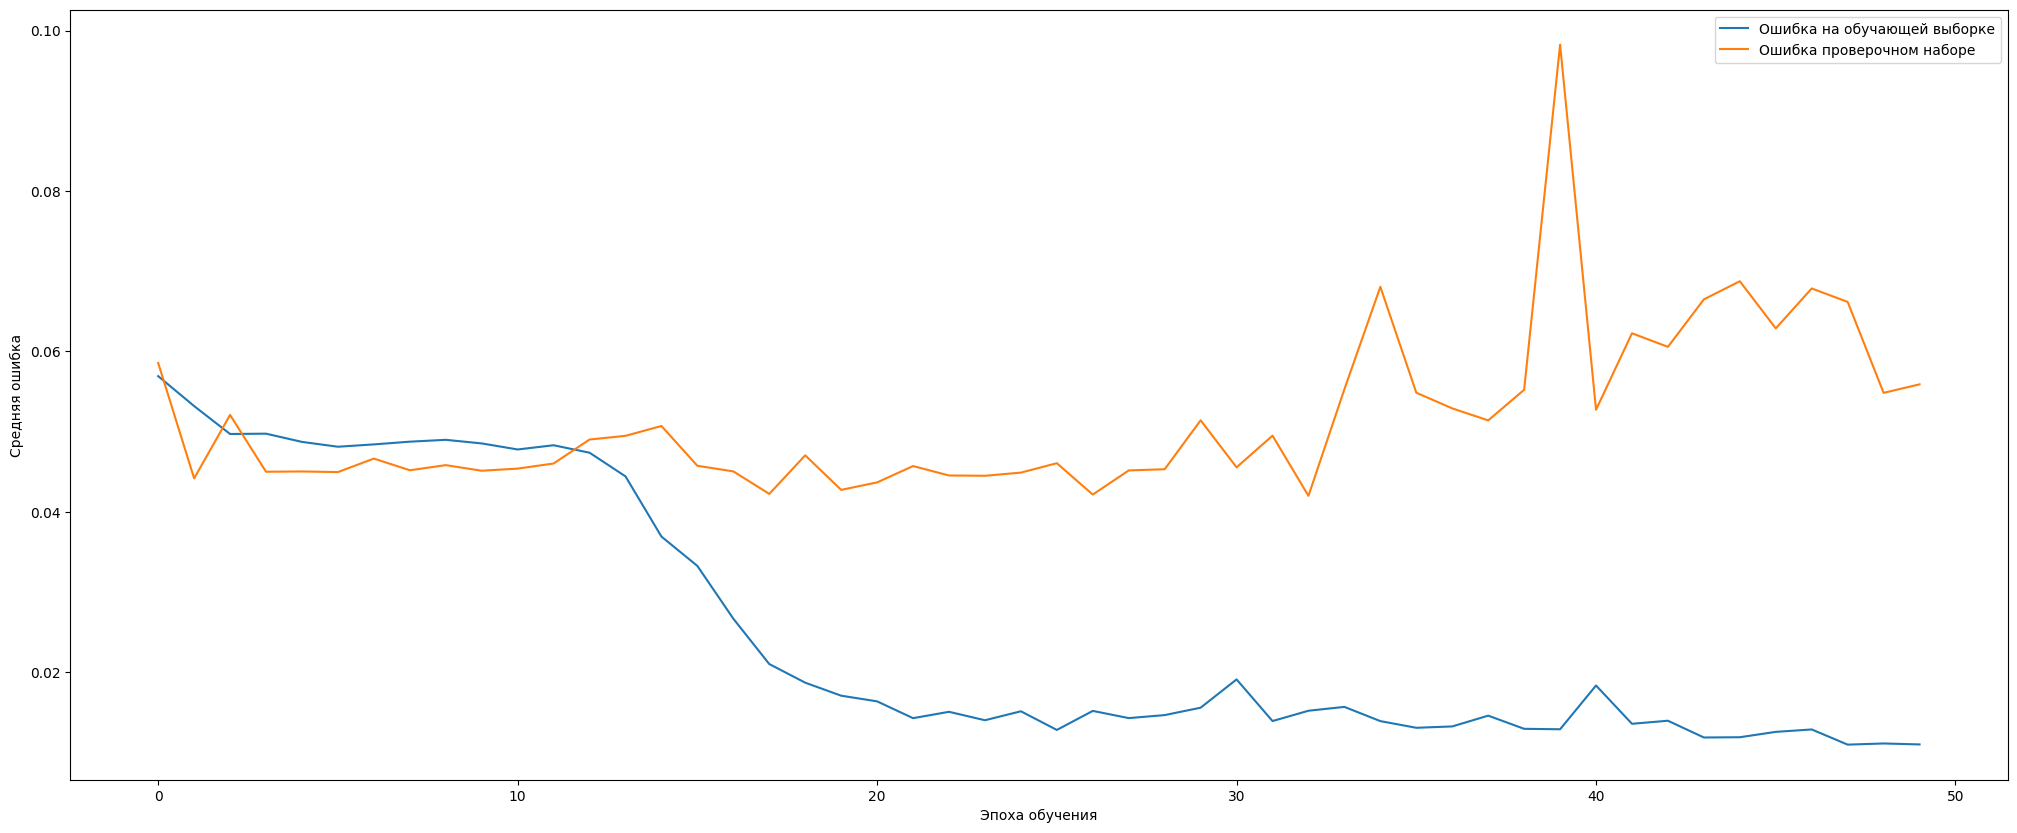

In [172]:
compare_sharp_loss(history, target = 'loss')

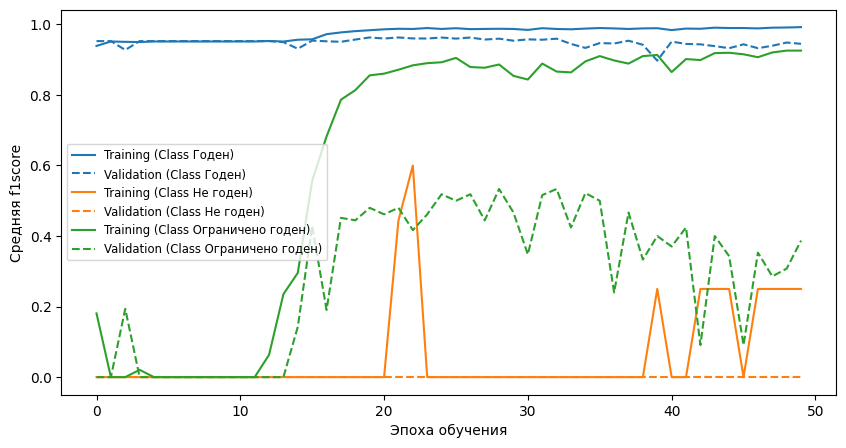

In [175]:
compare_f1_score(history, conclusion_le)

10/10 [==============================] - 3s 47ms/step


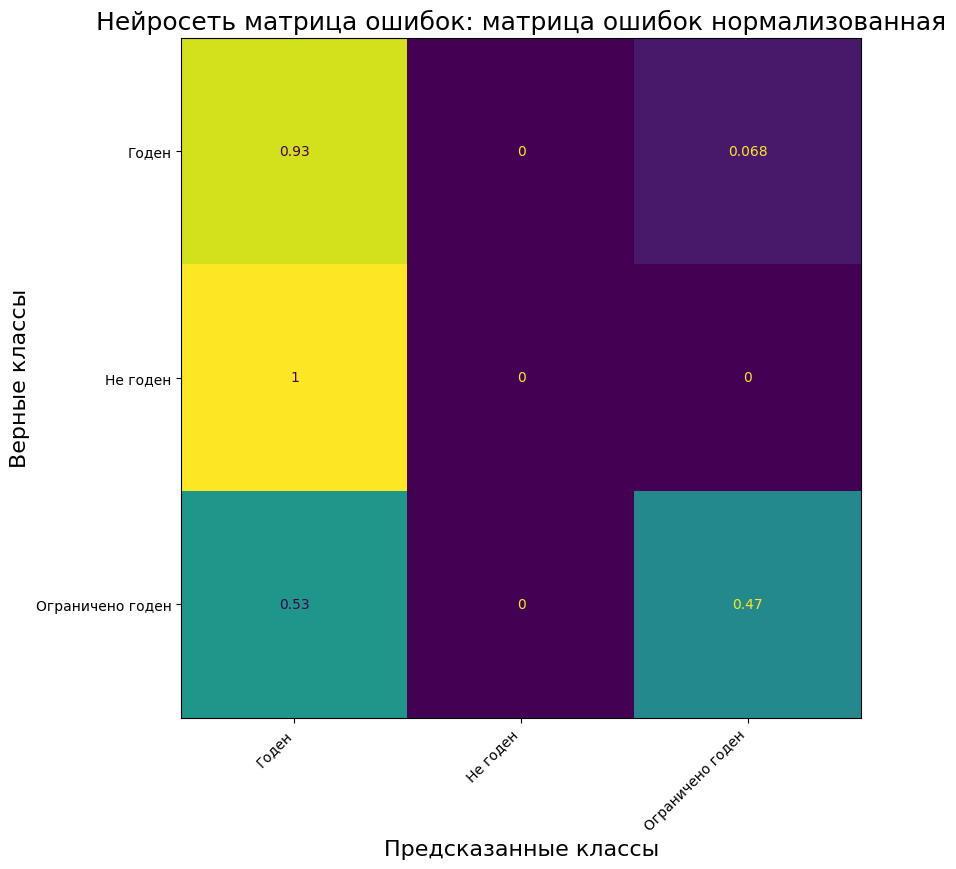

In [179]:
model_evaluate(best_model.predict(([
                x_test_categorical,
                x_test_prof,
                x_test_additions,
                x_test_diag
               ])),y_test)

# Выводы

Изначально предполагалось, что разбалансировка данных будет сильно влиять на точность модели и её стабильность.
Все варианты моделей , были склонны к переобучению на данном датасет.

Помимо решения расбалансировки данных, больший датасет позволил бы полнее представить выборки связанные с такими категориями как профессия, вредные факторы, и заключения специалистов.

Возможно на данном этапе было бы уместно испльзовать рекомендации на основе приказа  №29Н, без использования нейросети.
